# Path to images zipfile

In [2]:
!tar -xvf  '/content/drive/MyDrive/Copy of nyu_depth_images.tar' -C './'

nyu_depth_images/
nyu_depth_images/image1.png
nyu_depth_images/image10.png
nyu_depth_images/image100.png
nyu_depth_images/image1000.png
nyu_depth_images/image1001.png
nyu_depth_images/image1002.png
nyu_depth_images/image1003.png
nyu_depth_images/image1004.png
nyu_depth_images/image1005.png
nyu_depth_images/image1006.png
nyu_depth_images/image1007.png
nyu_depth_images/image1008.png
nyu_depth_images/image1009.png
nyu_depth_images/image101.png
nyu_depth_images/image1010.png
nyu_depth_images/image1011.png
nyu_depth_images/image1012.png
nyu_depth_images/image1013.png
nyu_depth_images/image1014.png
nyu_depth_images/image1015.png
nyu_depth_images/image1016.png
nyu_depth_images/image1017.png
nyu_depth_images/image1018.png
nyu_depth_images/image1019.png
nyu_depth_images/image102.png
nyu_depth_images/image1020.png
nyu_depth_images/image1021.png
nyu_depth_images/image1022.png
nyu_depth_images/image1023.png
nyu_depth_images/image1024.png
nyu_depth_images/image1025.png
nyu_depth_images/image1026.pn

In [3]:
!pip install -U keras
!pip install transformers
!pip install gputil
!pip install psutil
!pip install humanize
!pip install nltk

Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
     |████████████████████████████████| 2.1MB 7.2MB/s 
     |████████████████████████████████| 901kB 35.1MB/s 
     |████████████████████████████████| 3.3MB 55.5MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=cbd8cf9a1c51bbf8f89d8a481fa316aee4df341c4317f417db83db42c6e87217
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [1]:
import os, re, random, zipfile, pickle, torch, logging
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer
from time import time, sleep
from models import SelfVQA
from string import punctuation
from torch.optim import SGD, Adam, lr_scheduler
from sklearn.metrics import confusion_matrix
from torch.utils.data import (
    TensorDataset,
    Dataset,
    DataLoader, 
    Subset, 
    RandomSampler, SequentialSampler
)
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)
from PIL import Image, ImageFilter, ImageDraw
from torchvision.models import vgg16_bn
from torchvision.transforms import ToTensor
from transformers import get_linear_schedule_with_warmup
# import nltk
# nltk.download('wordnet')
# from nltk.corpus import wordnet

In [2]:
def download_dirs(dirlist):
    from google.colab import files
    for dirname in dirlist:
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)
            files.download(filename)
            
def get_dataLoader(dataset, splits, batch_sizes, shuffle_indices, **kwargs):
    n_samples = len(dataset)
    indices = list(range(n_samples))
    if shuffle_indices:
        np.random.shuffle(indices)
    split_index = int(n_samples*splits[0])
    train_indices = indices[:split_index]
    valid_indices = indices[split_index:]
    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)
    train_loader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_sizes[0], **kwargs
    )
    valid_loader = DataLoader(
        valid_dataset, shuffle=False, batch_size=batch_sizes[1], **kwargs
    )
    return train_loader, valid_loader

def fix_seed(seed_value, random_lib=False, numpy_lib=False, torch_lib=False):
    if random_lib:
        random.seed(seed_value)
    if numpy_lib:
        np.random.seed(seed_value)
    if torch_lib:
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

def setup_logger(name, format=None, level=logging.DEBUG, handlers=None, log_file='default.log'):
    logging.basicConfig(
        level=level, 
        format=format if format else '%(asctime)s [%(levelname)s] %(message)s',
        handlers=handlers if handlers else [
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(name)
    logger.setLevel(level)

def cal_accuracy(pred_labels, true_labels):
    _, pred_labels = pred_labels.max(dim=1)
    true_labels = true_labels.view(-1)
    return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]

def cal_wups(pred_labels, true_labels, label2word):
    print(pred_labels)
    print(true_labels)
    pred_labels = pred_labels.tolist()
    true_labels = true_labels.tolist()
    wups_scores = []
    for i in range(len(pred_labels)):
        pred_syn = wordnet.synsets(label2word[pred_labels[i]])
        true_syn = wordnet.synsets(label2word[true_labels[i]])
        mid_score = []
        for psyn in pred_syn:
            for tsyn in true_syn:
                score = psyn.wup_similarity(tsyn)
                if score:
                    mid_score.append(score)
        mean_score = np.mean(mid_score)
        if not np.isnan(mean_score):
            wups_scores.append(mean_score)
    return np.mean(wups_scores)

In [3]:
class SelfDataset(Dataset):

    def __init__(self, ant_df, images_dir, tokenizer=None, transform=ToTensor()):
        self.ant_df = ant_df
        self.encoded_matrix, self.vocab_size, self.tokenizer = encode_txt(
            list(ant_df.question.values), tokenizer
        )
        self.encoded_matrix = torch.as_tensor(self.encoded_matrix)
        self.image_names = list(ant_df.image_name.values)
        self.images_dir = images_dir
        self.labels = torch.as_tensor(ant_df.answer_id.values)
        self.transform = transform

    def __getitem__(self, item):
        question = self.encoded_matrix[item]
        image_name = os.path.join(self.images_dir, self.image_names[item])
        img = Image.open(image_name)
        if self.transform:
            img = self.transform(img)
        label = self.labels[item]
        return question, img, label

    def __len__(self):
        return len(self.labels)

class TrainTest():
    def __init__(self, model, optimizer, scheduler, criterion, logger=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.logger = logger
        self.tr_metrics = {
            'train_loss':[],
            'train_accuracy':[],
            'valid_loss':[],
            'valid_accuracy':[],
        }
        
    def train(
        self, train_loader, valid_loader, 
        num_epochs, device, eval_interval,
        clip=None, model_path=None, save_per_epoch=None,
        results_path=None, defaults=None, **kwargs
    ):
        total_itrs = num_epochs*len(train_loader)
        num_tr, total_tr_loss, itr = 0, 0, 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, (questions, imgs, labels) in enumerate(train_loader):
                questions = questions.to(device)
                imgs = imgs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(
                    questions,
                    imgs
                )
                tr_loss = self.criterion(output, labels.view(-1))
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                if self.logger:
                    self.logger.info(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                num_tr += 1
                total_tr_loss += tr_loss
                if itr % eval_interval == 0 or itr+1 == total_itrs:
                    self.tr_metrics['train_loss'].append(total_tr_loss.cpu().item()/num_tr)
                    tr_accuracy = cal_accuracy(output, labels)
                    self.tr_metrics['train_accuracy'].append(tr_accuracy)
                    num_tr, total_tr_loss = 0, 0
                    val_loss = 0
                    self.model.eval()
                    val_accuracy = []
                    with torch.no_grad():
                        for i, (val_questions, val_imgs, val_labels) in enumerate(valid_loader):
                            val_questions = val_questions.to(device)
                            val_imgs = val_imgs.to(device)
                            val_labels = val_labels.to(device)
                            self.optimizer.zero_grad()
                            val_output = self.model(
                                val_questions,
                                val_imgs
                            )
                            val_loss += self.criterion(val_output, val_labels.view(-1))
                            val_accuracy.append(cal_accuracy(val_output, val_labels))
                    self.tr_metrics['valid_accuracy'].append(np.mean(val_accuracy))
                    self.tr_metrics['valid_loss'].append(val_loss.cpu().item()/len(valid_loader))
                    self.model.train()
                    if self.logger:
                        self.logger.info(f'Training: iteration: {itr}/{total_itrs} -- epoch: {epoch} -- '
                        f' train_loss: {self.tr_metrics["train_loss"][-1]:.3f} -- train_accuracy: {self.tr_metrics["train_accuracy"][-1]:.2f}'
                        f' valid_loss: {self.tr_metrics["valid_loss"][-1]:.3f} -- valid_accuracy: {self.tr_metrics["valid_accuracy"][-1]:.2f}')
                itr += 1
            if model_path and results_path and ((epoch+1) % save_per_epoch == 0) and epoch != 0:
                self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_train')
                self.save_results(results_path, f'{epoch+1}_epochs_train', self.tr_metrics)
        if model_path and results_path:
            self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_last_train')
            self.save_results(results_path, f'{epoch+1}_epochs_last_train', self.tr_metrics)
            
    def save_model(self, epoch, model_path, name):
        model_dir = '/'.join(model_path.split('/')[:-1])
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': self.tr_metrics['valid_loss'][-1],
            }, os.path.join(model_dir, f'model_{name}.pt')
        )
        if self.logger:
            self.logger.info(f'Training: model saved to: {model_dir}/model_{name}.pt')
    
    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)
        if self.logger:
            self.logger.info(f'Training: results saved to: {results_dir}/resutls_{name}.pkl')

    def test(self, test_loader, device, label2word, results_path=None, defaults=None):
        test_accuracy, test_true, test_pred = [], [], []
        test_loss = 0
        self.model.eval()
        with torch.no_grad():
            for i, (test_questions, test_imgs, test_labels) in enumerate(test_loader):
                test_questions = test_questions.to(device)
                test_imgs = test_imgs.to(device)
                test_labels = test_labels.to(device)
                self.optimizer.zero_grad()
                test_output = self.model(
                    test_questions,
                    test_imgs
                )
                test_loss += self.criterion(test_output, test_labels.view(-1))
                test_accuracy.append(cal_accuracy(test_output, test_labels))
                test_true.append(test_labels.cpu())
                test_pred.append(test_output.cpu().max(dim=1)[1])
        test_true = torch.cat(test_true)
        test_pred = torch.cat(test_pred)
        test_loss = test_loss.cpu().item()/len(test_loader)
        test_accuracy = np.mean(test_accuracy)
        test_wups = cal_wups(test_pred, test_true, label2word)
        prf = precision_recall_fscore_support(
            test_true,
            test_pred,
            labels=list(label2word.keys()),
            average='weighted'
        )
        confm = confusion_matrix(test_true, test_pred, labels=list(label2word.keys()))
        self.ts_metrics = {
            'loss':test_loss,
            'accuracy':test_accuracy,
            'wups':test_wups,
            'precision':prf[0],
            'recall':prf[1],
            'f1_score':prf[2],
            'confusion_matrix':confm
        }
        if self.logger:
            print(f'Testing: test_loss: {test_loss:.3f} -- test_accurcy: {test_accuracy:.2f} -- test_wups: {test_wups:.2f}')
        if results_path:
            self.save_results(results_path, f'test', self.ts_metrics)

In [4]:
def resize_images(resize_shape, images_path, img_dist_path='rescaled_images'):
    if not os.path.exists(img_dist_path):
        os.makedirs(img_dist_path)
    else: return img_dist_path
    image_names = sorted(os.listdir(images_path))
    img_counter = 0
    for img_file in image_names:
        img = Image.open(os.path.join(images_path, img_file))
        img.thumbnail(resize_shape, Image.ANTIALIAS)
        new_path = os.path.join(img_dist_path, img_file)
        img.save(new_path, format='PNG')
        img_counter += 1
    return img_dist_path

def create_df(file_path, answer_mapping=None):
    with open(file_path, 'r') as annotation_file:
        questions = []
        answers = []
        image_names = []
        chars = set('_,')
        lines = annotation_file.readlines()
        for i in range(0, len(lines)-1, 2):
            question = lines[i].strip().split()
            answer = lines[i+1].strip()
            if answer_mapping and answer not in answer_mapping.keys():
                continue
            if not any((c in chars) for c in answer):
                image_name = question.pop(-2)
                image_names.append(image_name[image_name.index('image'):]+'.png')
                answers.append(answer)
                questions.append(' '.join(question[:-3])+'?')
    df = pd.DataFrame(
        list(zip(image_names, questions, answers)), columns=['image_name', 'question', 'answer']
    ).sort_values(['image_name']).reset_index(drop=True)
    valid_answers = np.sort(df.answer.unique())
    if not answer_mapping:
        answer_mapping = dict(zip(valid_answers, range(len(valid_answers))))
    df['answer_id'] = df.answer.apply(lambda x: answer_mapping[x])
    return df, answer_mapping

def encode_txt(txt_list, tokenizer=None):
    if tokenizer is None:
        print('train tokenizer')
        tokenizer = Tokenizer(oov_token='OOV')
        tokenizer.fit_on_texts(txt_list)
    vocab_size = len(tokenizer.word_index) + 1
    encoded_txt = tokenizer.texts_to_sequences(txt_list)
    encoded_matrix = pad_sequences(
        encoded_txt,
        padding='pre',
        truncating='pre'
    )
    return encoded_matrix, vocab_size, tokenizer

In [5]:
cuda_flag = True if torch.cuda.is_available() else False
lrlast = .001
lrmain = .00001
n_iters = 10000
num_epochs = 12
eval_interval = 150
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True} if cuda_flag else {}
data_splits = [0.9, 0.1]
batch_sizes = [8, 8]
seed = 20214
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

# Set Path to images directory and annotation files for training and test data

In [6]:
resize_shape = (200, 200)
resized_dir = resize_images(resize_shape, './nyu_depth_images/', './rescaled_images/')
tr_ant_path = './qa.894.raw.train.txt'
train_df, answer_mapping = create_df(tr_ant_path)
label2word = {v: k for k, v in answer_mapping.items()}
train_dataset = SelfDataset(train_df, resized_dir)
ts_ant_path = './qa.894.raw.test.txt'
test_df, _ = create_df(ts_ant_path, answer_mapping)
test_dataset = SelfDataset(test_df, resized_dir, train_dataset.tokenizer)

train_loader, valid_loader = get_dataLoader(
    train_dataset,
    data_splits,
    batch_sizes,
    shuffle_indices=True, **params
)
test_loader = DataLoader(
    test_dataset, shuffle=False, batch_size=8, **params
)

train tokenizer


# Set path to GloVe 300d embedding fil

In [12]:
embedded_words = dict()
glove_path = '/content/drive/MyDrive/Copy of glove.42B.300d.txt'
glove_file = open(glove_path)
for line in glove_file:
    values = line.split(' ')
    word = values[0]
    words_weights = np.array(values[1:], dtype='float32')
    embedded_words[word] = words_weights
glove_file.close()

In [13]:
mean_embedding = np.array(list(embedded_words.values())).mean(axis=0)
embedding_dim = len(embedded_words[next(iter(embedded_words))])
embedding_matrix = np.zeros((train_dataset.vocab_size, embedding_dim))
for word, index in train_dataset.tokenizer.word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = mean_embedding

del embedded_words

In [17]:
output_size = len(answer_mapping)
hidden_dim = 150
n_layers = 1
lstm_drop = 0.5

model = SelfVQA(
    train_dataset.vocab_size,
    output_size,
    embedding_dim,
    hidden_dim,
    n_layers,
    lstm_drop,
    bidirectional=True
).to(device)

embedding_matrix = torch.as_tensor(embedding_matrix, dtype=torch.float)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad=False
for param in model.vgg.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [18]:
optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = SGD(model.parameters(), lr=lrmain)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0,
    num_training_steps = num_epochs*len(train_loader),
)
open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', level=logging.INFO, log_file='metrics.log')

In [19]:
traintest = TrainTest(model, optimizer, scheduler, F.nll_loss, logger)
traintest.train(
    train_loader,
    valid_loader,
    num_epochs,
    device,
    eval_interval,
    model_path='./models/',
    save_per_epoch=10,
    results_path='./results/',
    clip=5
)

Streaming output truncated to the last 5000 lines.
2021-04-25 17:51:36,698 [INFO] Training: 1890/6852 -- loss: 2.6486988067626953
2021-04-25 17:51:36,747 [INFO] Training: 1891/6852 -- loss: 3.3164992332458496
2021-04-25 17:51:36,796 [INFO] Training: 1892/6852 -- loss: 2.936614513397217
2021-04-25 17:51:36,848 [INFO] Training: 1893/6852 -- loss: 2.658435344696045
2021-04-25 17:51:36,896 [INFO] Training: 1894/6852 -- loss: 2.699702024459839
2021-04-25 17:51:36,944 [INFO] Training: 1895/6852 -- loss: 2.7893033027648926
2021-04-25 17:51:36,992 [INFO] Training: 1896/6852 -- loss: 2.677666664123535
2021-04-25 17:51:37,042 [INFO] Training: 1897/6852 -- loss: 2.81429386138916
2021-04-25 17:51:37,091 [INFO] Training: 1898/6852 -- loss: 2.023453712463379
2021-04-25 17:51:37,142 [INFO] Training: 1899/6852 -- loss: 4.038838863372803
2021-04-25 17:51:37,190 [INFO] Training: 1900/6852 -- loss: 3.213956594467163
2021-04-25 17:51:37,239 [INFO] Training: 1901/6852 -- loss: 3.5561327934265137
2021-04-25

In [25]:
traintest.test(test_loader, device, label2word, results_path='./results/')

/content/models.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_logits = F.log_softmax(logits)


tensor([209,  21,   0,  ...,   9, 211,  28])
tensor([206,  68,  11,  ...,  11, 222,  43])


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021-04-25 18:01:19,870 [INFO] Training: results saved to: ./results/resutls_test.pkl


Testing: test_loss: 3.300 -- test_accurcy: 0.29 -- test_wups: 0.49


In [21]:
download_dirs(['./results/'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
traintest.tr_metrics

{'train_accuracy': [0.0,
  0.0,
  0.125,
  0.25,
  0.25,
  0.125,
  0.0,
  0.125,
  0.0,
  0.125,
  0.25,
  0.0,
  0.25,
  0.375,
  0.25,
  0.125,
  0.625,
  0.25,
  0.5,
  0.375,
  0.25,
  0.75,
  0.125,
  0.5,
  0.375,
  0.375,
  0.25,
  0.75,
  0.25,
  0.375,
  0.25,
  0.75,
  0.5,
  0.25,
  0.75,
  0.125,
  0.5,
  0.625,
  0.625,
  0.25,
  0.625,
  0.375,
  0.75,
  1.0,
  0.25,
  0.75,
  0.5714285714285714],
 'train_loss': [5.49746561050415,
  4.549512939453125,
  4.084267985026042,
  3.784013264973958,
  3.5651949055989585,
  3.4850537109375,
  3.2959336344401042,
  3.3679276529947915,
  3.2670263671875,
  3.185530802408854,
  3.0925,
  3.0877278645833335,
  2.886314697265625,
  2.868921712239583,
  2.795571492513021,
  2.8647607421875,
  2.726148885091146,
  2.579697469075521,
  2.5985858154296877,
  2.7485972086588544,
  2.3664036051432293,
  2.476529337565104,
  2.5094720458984376,
  2.4417911783854165,
  2.2969203694661458,
  2.3583579508463544,
  2.213961385091146,
  2.139975

In [23]:
answer_mapping

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '14': 4,
 '15': 5,
 '16': 6,
 '18': 7,
 '19': 8,
 '2': 9,
 '22': 10,
 '3': 11,
 '4': 12,
 '5': 13,
 '6': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 'alarm': 18,
 'album': 19,
 'backpack': 20,
 'bag': 21,
 'ball': 22,
 'balloon': 23,
 'banana': 24,
 'banister': 25,
 'basket': 26,
 'bathtub': 27,
 'bed': 28,
 'belt': 29,
 'bench': 30,
 'bicycle': 31,
 'bin': 32,
 'binder': 33,
 'black': 34,
 'blackboard': 35,
 'blanket': 36,
 'blinds': 37,
 'blue': 38,
 'board': 39,
 'book': 40,
 'bookrack': 41,
 'books': 42,
 'bookshelf': 43,
 'bottle': 44,
 'bowl': 45,
 'box': 46,
 'bread': 47,
 'brick': 48,
 'briefcase': 49,
 'broom': 50,
 'brown': 51,
 'bucket': 52,
 'bulb': 53,
 'cabinet': 54,
 'cables': 55,
 'calculator': 56,
 'calendar': 57,
 'can': 58,
 'candelabra': 59,
 'candle': 60,
 'candlestick': 61,
 'cane': 62,
 'carton': 63,
 'case': 64,
 'cd': 65,
 'ceiling': 66,
 'certificate': 67,
 'chair': 68,
 'chandelier': 69,
 'charger': 70,
 'chart': 71,
 'chessboar

In [4]:
def report_results(
    results_dir, train_results_file, eval_interval, just_train=False,
    test_results_file=None, class_mapping=None, **kwargs
):
    with open(os.path.join(results_dir, train_results_file), 'rb') as results_file:
        train_results = pickle.load(results_file)
    iterations = [i*eval_interval for i in range(len(train_results['train_loss']))]
    plt.plot(iterations, train_results['train_loss'], label=f'train loss')
    plt.plot(iterations, train_results['valid_loss'], label=f'valid loss')
    plt.title('Loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 'train-validation-loss.png'), dpi=300, bbox_inches="tight")
    plt.figure()
    plt.plot(iterations, train_results['train_accuracy'], label=f'train accuracy')
    plt.plot(iterations, train_results['valid_accuracy'], label=f'valid accuracy')
    plt.title('Accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 'train-validation-accuracy.png'), dpi=300, bbox_inches="tight")
    if not just_train:
        with open(os.path.join(results_dir, test_results_file), 'rb') as results_file:
            test_results = pickle.load(results_file)
        class_mapping = sorted(
            list(class_mapping.items()), key=lambda x: x[1]
        )
        classes = [x[0] for x in class_mapping]
        plt.figure()
        test_confm = pd.DataFrame(test_results['confusion_matrix'], classes, classes)
        sn.set(font_scale=1)
        sn.heatmap(
            test_confm, 
            annot=kwargs['conf_annot'] if 'conf_annot' in kwargs else True, 
            annot_kws={"size": kwargs['font-size'] if 'font-size' in kwargs else 10}
        )
        plt.autoscale(True)
        plt.savefig(os.path.join(results_dir, 'test-confusion-matrix.png'), dpi=300, bbox_inches="tight")
        print(f'{"*"*20} Test Metrics: {"*"*20}\n'
              f'Loss: {test_results["loss"]:.3f}\n'
              f'Accuracy: {test_results["accuracy"]:.3f}\n'
              f'WUPS: {test_results["wups"]:.3f}\n'
              f'Weighted Precision: {test_results["precision"]:.3f}\n'
              f'Weighted Recall: {test_results["recall"]:.3f}\n'
              f'Weighted F1-score: {test_results["f1_score"]:.3f}\n'
              f'{"*"*55}')

******************** Test Metrics: ********************
Loss: 3.300
Accuracy: 0.287
WUPS: 0.493
Weighted Precision: 0.242
Weighted Recall: 0.287
Weighted F1-score: 0.253
*******************************************************


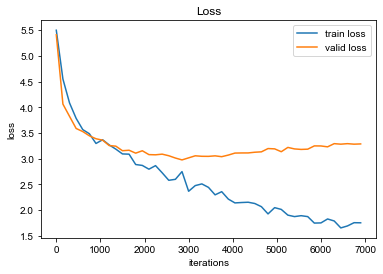

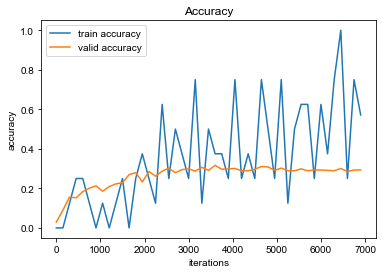

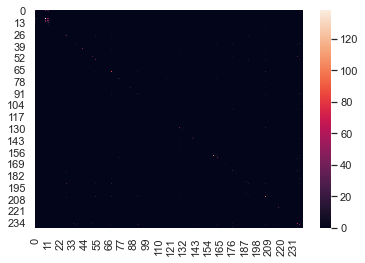

In [7]:
results_dir = 'VQA-results'
test_results_file = 'results_test.pkl'
train_results_file = 'results_12_epochs_last_train.pkl'
report_results(
    results_dir, train_results_file, eval_interval,
    test_results_file=test_results_file,
    class_mapping=dict(zip(range(len(answer_mapping)), range(len(answer_mapping)))), conf_annot=False
)